In [9]:
import ROOT as r
import os
import sys
import pandas as pd
import numpy as np
import cmsstyle as cms
from array import array

In [37]:
mqLumis = pd.read_json('/eos/experiment/milliqan/Configs/mqLumis.json', orient = 'split', compression = 'infer')
mqLumis['start'] = pd.to_datetime(mqLumis['start'])
mqLumis['stop'] = pd.to_datetime(mqLumis['stop'])

goodRuns = pd.read_json('/eos/experiment/milliqan/Configs/goodRunsList.json', orient = 'split', compression = 'infer')

mqLumis = mqLumis.merge(goodRuns, on=['run', 'file'])
mqLumis = mqLumis[mqLumis['goodRunMedium']==True]

23821.0
23409.0 10171.435323097232 0.4345096041307716
Correction: 10171.435323097232 muons over 16096891s, rate 0.0006318881902783111
17763.403773995862 7718.3695418539955 0.43450960413077155
 FCN=50.5 FROM HESSE     STATUS=OK             16 CALLS         200 TOTAL
                     EDM=1.99754e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.58115e+02   6.65714e+00   3.90537e-03  -1.61174e-05
   2  Mean        -1.59448e+01   7.38861e-02   3.50444e-05   3.14440e-03
   3  Sigma        5.72959e+00   5.28976e-02   1.47436e-06  -9.42458e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::Print>: png file plots/beamOffFit.png has been created


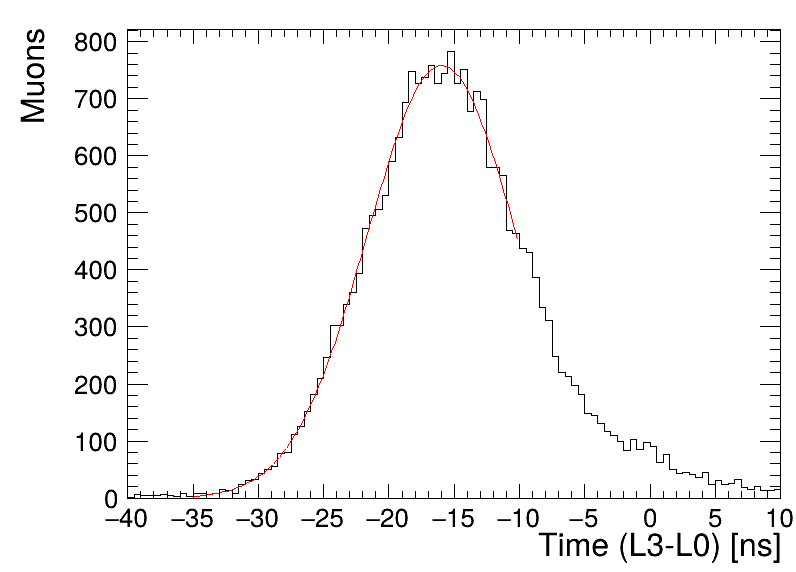

In [38]:
#r.gStyle.SetOptStat(111111)

c2 = r.TCanvas("c2", "c2", 800, 600)
fOff = r.TFile.Open('beamMuonRate_off300AllBars.root', 'READ')
h = fOff.Get('h_timeDiffL30')
h.GetXaxis().SetRangeUser(-40, 10)

'''hShift = r.TH1F('hShift', '', h.GetNbinsX(), h.GetBinLowEdge(0)+20, h.GetXaxis().GetXmax()+20)

for bin in range(h.GetNbinsX()):
    #print(bin, h.GetBinContent(bin))
    hShift.SetBinContent(bin, h.GetBinContent(bin))

hShift.GetXaxis().SetRangeUser(0, 35)'''


#f = r.TF1('f1', "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp(-([1]/[2])))/TMath::Gamma((x/[2])+1.)", 0, 35)
f = r.TF1('f1', 'gaus', -1000, 1000)
f.SetParameter(0, 500)
#f.SetParLimits(0, 100, 1000)
f.SetParameter(1, 10)
#f.SetParLimits(1, 5, 10)
f.SetParameter(2, 5)
#f.SetParLimits(2, 0, 1)
h.Fit(f, "M", "", -35, -10)

h.SetTitle(';Time (L3-L0) [ns];Muons')
h.Draw()
c2.Draw()

histTotal = h.Integral()
fitTotal = f.Integral(-r.TMath.Infinity(), r.TMath.Infinity())

scale = histTotal/fitTotal
f.SetParameter(0, f.GetParameter(0)*scale)

print(h.Integral(0, h.GetNbinsX(), ""))
total = f.Integral(-r.TMath.Infinity(), r.TMath.Infinity())
passing = f.Integral(-15, r.TMath.Infinity())
ratio = passing/total
print(total, passing, ratio)

beamOffTime = 16096891
beamOnTime = 12214771


correction = passing/beamOffTime
print(f'Correction: {passing} muons over {beamOffTime}s, rate {passing/beamOffTime}')

#fScaled = r.TF1('fScaled', f'f*{beamOnTime}/{beamOffTime}')

f.SetParameter(0, f.GetParameter(0)*beamOnTime/beamOffTime)

total = f.Integral(-r.TMath.Infinity(), r.TMath.Infinity())
passing = f.Integral(-15, r.TMath.Infinity())
ratio = passing/total
print(total, passing, ratio)
c2.SaveAs('plots/beamOffFit.png')

In [50]:
#fin = r.TFile.Open('beamMuonRate_on300AllBars.root', 'READ')
fin = r.TFile.Open('beamMuonArea_beamOn_300kDebug.root', 'READ')


#fin = r.TFile.Open('beamMuonRate_on300AllStraightPanelReq.root', 'READ')


c1 = r.TCanvas("c1", "c1", 800, 600)

h_muons = fin.Get('h_beamMuonPerRun')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


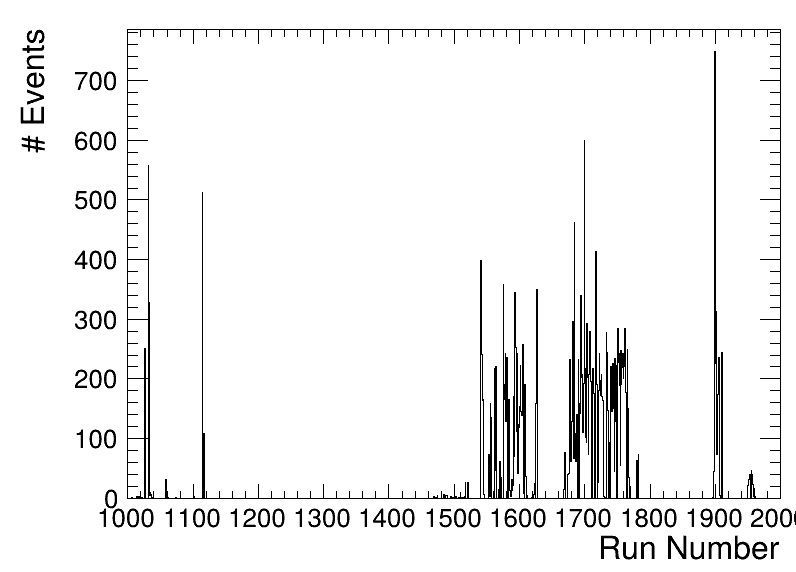

In [51]:
r.gStyle.SetOptStat(0)
h_muons.Draw()
c1.Draw()

In [52]:
g_muonRates = r.TGraphErrors()

points=0
lumiTotal=0
muonTotal=0
timeTotal = 0

lumiPoints = []
muonPoints = []
lumiErr = []
muonErr = []

for ibin in range(h_muons.GetNbinsX()):
    count = h_muons.GetBinContent(ibin)
    runNum = ibin+999
    #if runNum < 1487: continue
    if count > 0:
        lumis = round(mqLumis['lumiEst'][mqLumis['run'] == runNum].sum(), 2)
        time = (mqLumis['stop'][(mqLumis['run'] == runNum) & (mqLumis['beamInFill'])] - mqLumis['start'][(mqLumis['run'] == runNum) & (mqLumis['beamInFill'])]).sum()
        timeTotal+=time.total_seconds()

        countCorrected = count - (correction * time.total_seconds())
        
        lumiTotal+=lumis
        muonTotal+=countCorrected
        g_muonRates.SetPoint(points, lumiTotal, muonTotal)
        g_muonRates.SetPointError(points, lumiTotal*0.06, np.sqrt(muonTotal))
        lumiPoints.append(lumiTotal)
        muonPoints.append(muonTotal)
        lumiErr.append(lumiTotal*0.06)
        muonErr.append(np.sqrt(muonTotal))
        #if (count>0): print(f"Run: {runNum}, count {muonTotal}, lumis: {lumiTotal}, rate: {count/lumis}")
        points += 1

lumiPoints = array('d', [round(x, 3) for x in lumiPoints])
muonPoints = array('d', [round(x, 3) for x in muonPoints])
lumiErr = array('d', [round(x, 3) for x in lumiErr])
muonErr = array('d', [round(x, 3) for x in muonErr])

lumiLow = [l-e for l,e in zip(lumiPoints, lumiErr)]
lumiHigh = [l+e for l,e in zip(lumiPoints, lumiErr)]
muonLow = [l-e for l,e in zip(muonPoints, muonErr)]
muonHigh = [l+e for l,e in zip(muonPoints, muonErr)]

lumiLow.append(lumiLow[-1])
muonLow.append(muonHigh[-1])

lumiErrors = array('d', np.concatenate([lumiLow, lumiHigh[::-1]]))
muonErrors = array('d', np.concatenate([muonLow, muonHigh[::-1]]))

g_muonRates = r.TGraph(len(lumiPoints), lumiPoints, muonPoints)
g_muonRateErr = r.TGraph(2*len(lumiPoints), lumiErrors, muonErrors)
#g_muonRateHigh = r.TGraph(len(lumiPoints), lumiHigh, muonHigh)


print(lumiTotal, muonTotal, muonTotal/lumiTotal, timeTotal)

124603.54999999996 19955.14173742401 0.16014906266654536 12163320.0


In [53]:
c1 = cms.cmsCanvas('c1',0,100e3,1,200,"Area [pVs]","Pulses",iPos=0, square=True)
#c1 = r.TCanvas("c1", "c1", 800, 600)
r.gStyle.SetOptFit(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [54]:
c1.Clear()
r.gStyle.SetOptFit(0)

f1 = r.TF1("f1", "[0]*x", 0, 150e3)
f1.SetParameter(0, 1)

g_muonRates.SetTitle(";Luminosity [pb^{-1}];Muons")
g_muonRates.GetYaxis().SetTitleOffset(1.8)

g_muonRates.Fit(f1, "WWMQ0", "", 0, 150e3)

g_band = g_muonRates.Clone()
g_band.SetFillColor(r.kGreen)
#cms.cmsDraw(g_band, 'E3')
#g_band.Draw('3')
g_muonRates.GetYaxis().SetRangeUser(0, 23000)
g_muonRateErr.SetFillColor(r.kGreen)

#cms.cmsDraw(g_muonRates, 'L')
#g_muonRates.Draw('A3')
g_muonRateErr.SetFillStyle(1001)
g_muonRateErr.SetFillColorAlpha(r.kGreen, 0.3)

g_muonRates.Draw('AL')
g_muonRates.SetMarkerStyle(2)
g_muonRates.SetLineStyle(1)
g_muonRates.SetLineWidth(3)
g_muonRateErr.Draw("F")

rate = f1.GetParameter(0)
err = f1.GetParError(0) + rate*np.sqrt((np.sqrt(muonTotal)/muonTotal)**2 + (lumiTotal*0.06/lumiTotal)**2)


print(rate, err)
t1 = r.TLatex()
t1.SetTextSize(0.035)
t1.DrawLatexNDC(0.25, 0.8, f'{rate:.3f}#pm {err:.3f} muons/pb^{{-1}}')

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.2, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.9, 0.94, "124.7 fb^{-1} (13.6 TeV)");

l1 = r.TLegend(0.25, 0.65, 0.35, 0.75)
l1.AddEntry(g_muonRates, 'Measured Muon Flux', 'l')
l1.AddEntry(g_muonRateErr, '1#sigma Error', 'f')
l1.Draw()

r.gPad.SetLeftMargin(0.2)
r.gPad.SetRightMargin(0.1)
r.gPad.SetBottomMargin(0.2)
c1.Draw()

0.15956636373759647 0.009816382140358092


In [55]:
r.gStyle.SetOptFit(0)
c1.Draw()
#c1.SaveAs('muonRateBars.png')

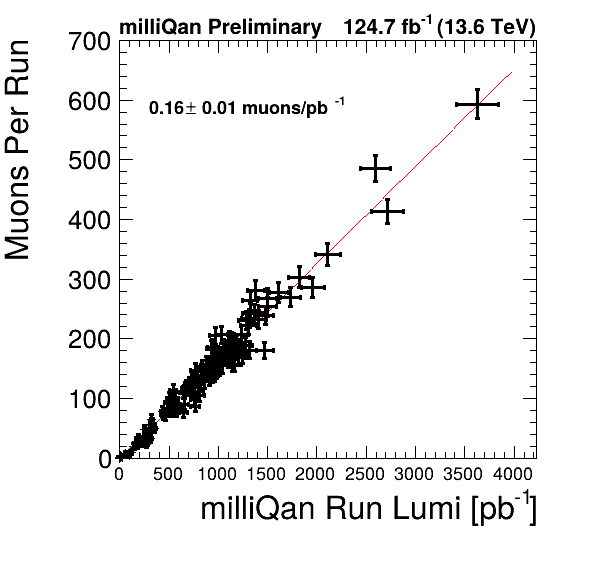

In [56]:
c1.Draw()

In [57]:
beamOffMuons = 6655

beamOnMuons = 27641

beamOffTime = 16096891
beamOnTime = 12214771

cosmicEst = beamOffMuons * beamOnTime/beamOffTime
print(cosmicEst)

beamOnCorrected = beamOnMuons -7718.3695418539955

correctedRate = beamOnCorrected / 124700

print(beamOnCorrected, correctedRate)

5050.0000903901255
19922.630458146006 0.1597644784133601


In [58]:
g_muonRates = r.TGraphErrors()

points=0
lumiTotal=0
muonTotal=0
timeTotal = 0

lumiPoints = []
muonPoints = []
lumiErr = []
muonErr = []

for ibin in range(h_muons.GetNbinsX()):
    count = h_muons.GetBinContent(ibin)
    runNum = ibin+999
    #if runNum < 1487: continue
    if count > 0:
        lumis = round(mqLumis['lumiEst'][mqLumis['run'] == runNum].sum(), 2)
        time = (mqLumis['stop'][(mqLumis['run'] == runNum) & (mqLumis['beamInFill'])] - mqLumis['start'][(mqLumis['run'] == runNum) & (mqLumis['beamInFill'])]).sum()
        timeTotal+=time.total_seconds()

        if lumis==0: continue

        countCorrected = count - (correction * time.total_seconds())
        
        #lumiTotal+=lumis
        #muonTotal+=countCorrected
        g_muonRates.SetPoint(points, lumis, countCorrected)
        g_muonRates.SetPointError(points, lumis*0.06, np.sqrt(countCorrected))
        #lumiPoints.append(lumis)
        #muonPoints.append(countCorrected)
        #lumiErr.append(lumis*0.06)
        #muonErr.append(np.sqrt(countCorrected))
        #if (count>0): print(f"Run: {runNum}, count {muonTotal}, lumis: {lumiTotal}, rate: {count/lumis}")
        points += 1



/tmp/ipykernel_471/122034352.py:29: RuntimeWarning: invalid value encountered in sqrt
  g_muonRates.SetPointError(points, lumis*0.06, np.sqrt(countCorrected))


In [59]:
c1.Clear()
r.gStyle.SetOptFit(0)

f1 = r.TF1("f1", "[0]*x", 0, 4e3)
f1.SetParameter(0, 1)

g_muonRates.SetTitle(";milliQan Run Lumi [pb^{-1}];Muons Per Run")
g_muonRates.GetYaxis().SetTitleOffset(1.8)

g_muonRates.Fit(f1, "WWMQ", "", 0, 4e3)

g_band = g_muonRates.Clone()
g_band.SetFillColor(r.kGreen)
#cms.cmsDraw(g_band, 'E3')
#g_band.Draw('3')
g_muonRates.GetYaxis().SetRangeUser(0, 700)
g_muonRateErr.SetFillColor(r.kGreen)

#cms.cmsDraw(g_muonRates, 'L')
#g_muonRates.Draw('A3')
g_muonRateErr.SetFillStyle(1001)
g_muonRateErr.SetFillColorAlpha(r.kGreen, 0.3)

g_muonRates.Draw('AP')
g_muonRates.GetXaxis().SetLabelSize(0.035)
g_muonRates.SetMarkerStyle(2)
g_muonRates.SetLineStyle(1)
g_muonRates.SetLineWidth(3)
#g_muonRateErr.Draw("F")

rate = f1.GetParameter(0)
#err = f1.GetParError(0) + rate*np.sqrt((np.sqrt(muonTotal)/muonTotal)**2 + (lumiTotal*0.06/lumiTotal)**2)


print(rate, err)
t1 = r.TLatex()
t1.SetTextSize(0.035)
t1.DrawLatexNDC(0.25, 0.8, f'{rate:.2f}#pm {err:.2f} muons/pb^{{-1}}')

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.2, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.9, 0.94, "124.7 fb^{-1} (13.6 TeV)");

l1 = r.TLegend(0.25, 0.7, 0.35, 0.8)
l1.AddEntry(g_muonRates, 'Measured Muon Flux', 'p')
#l1.AddEntry(g_muonRateErr, '1#sigma Error', 'f')
#l1.Draw()

r.gPad.SetLeftMargin(0.2)
r.gPad.SetRightMargin(0.1)
r.gPad.SetBottomMargin(0.2)
c1.Draw()

0.16297309406397853 0.009816382140358092


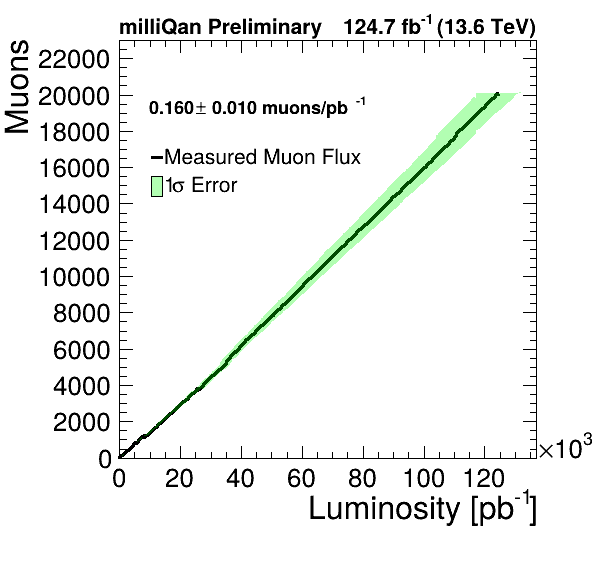

In [49]:
c1.Draw()
#c1.SaveAs('muonRateBarPerRun.png')